In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import statistics as stats

df = pd.read_csv('../../Data/SMTO_2019/SMTO_2019_Complete_Input.csv')
school_codes = df['School'].unique().tolist()
uni_codes = df[df['School_Type'] == 'University']['School'].unique().tolist()
df.head()

,Liv_Arr,Children,Cars,Income,Home_Zone,School,Campus,Work,Licence,Mode,...,Closest.SHD,Closest.SHH,Closest.SHT,Closest.MI,Closest.SC,Closest.SG,Closest.YK,Closest.YG,Closest.RY,Closest.OC
0,Live with family/parents,0.0,0.0,Unknown,3851.0,CPR,Progress Campus,NW,False,Transit,...,0,1,0,0,0,0,0,0,0,0
1,Live with family/parents,0.0,1.0,Unknown,181.0,CMO,Morningside Campus,NW,False,Transit,...,0,0,0,0,0,0,0,0,0,0
2,Live with family/parents,0.0,2.0,Unknown,1039.0,CPR,Progress Campus,NW,False,Transit,...,0,0,0,0,1,0,0,0,0,0
3,NaN,NaN,NaN,Unknown,191.0,CPR,Progress Campus,NW,False,NaN,...,0,0,0,0,0,0,0,0,0,0
4,Live with family/parents,1.0,1.0,Unknown,600.0,CPR,Progress Campus,NW,False,NaN,...,0,0,0,0,0,0,0,0,0,0


In [2]:
PD_df = pd.read_csv('../../Data/Zones.csv')
PD_df.set_index(PD_df['Zone#'],inplace = True)

def zone_to_PD(x):
    try:
        return PD_df['PD'][x]
    except:
        return -1

df['PD'] = df['Home_Zone'].apply(lambda x: zone_to_PD(x))

In [3]:
df = df[['School_Type', 'PD', 'Age', 'Cars', 'Family', 'Income', 'Closest', 'Licence']]

df['Income_High'] = (df['Income'] == 'High').astype(int)
df['Income_Low'] = (df['Income'] == 'Low').astype(int)

df['Family_True'] = (df['Family'] == True).astype(int)
df['Family_False'] = (df['Family'] == False).astype(int)

df['Closest_Col'] = ((~ df['Closest'].isin(uni_codes)) & (df['Family_False'])).astype(int)
df['Closest_Uni'] = ((df['Closest'].isin(uni_codes)) & (df['Family_False'])).astype(int)

df['Cars2+'] = (df['Cars'] >= 2).astype(int)
df['Cars1'] = (df['Cars'] == 1).astype(int)
df['Cars0'] = (df['Cars'] == 0).astype(int)

df['Licence_True'] = (df['Licence'] == 1).astype(int)
df['Licence_False'] = (df['Licence'] == 0).astype(int)

df = df.drop(columns = ['Cars', 'Family', 'Licence', 'Income', 'Closest'])
df.isnull().sum().sum()

0

In [4]:
df.dtypes

School_Type       object
PD                 int64
Age              float64
Income_High        int32
Income_Low         int32
Family_True        int32
Family_False       int32
Closest_Col        int32
Closest_Uni        int32
Cars2+             int32
Cars1              int32
Cars0              int32
Licence_True       int32
Licence_False      int32
dtype: object

In [5]:
# Define X and Y for the training set
y = df['School_Type']
x = df.drop(columns=['School_Type'])

# --- RUN Random Forest Model --- #
rf = RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rf.feature_importances_

array([0.48005828, 0.34519703, 0.01743966, 0.025441  , 0.01308209,
       0.00913954, 0.01900934, 0.01691504, 0.01396787, 0.01146304,
       0.01227486, 0.02003438, 0.01597788])

In [6]:
# --- Confusion Matrix ---
CM = pd.DataFrame(confusion_matrix(y_test, y_pred))
CM.rename(columns = {0: 'Pred_Col', 1: 'Pred_Uni'}, index = {0: 'Obs_Col', 1: 'Obs_Uni'}, inplace = True)
CM

,Pred_Col,Pred_Uni
Obs_Col,380,658
Obs_Uni,305,3612


In [7]:
f1_score(y_test, y_pred, average=None)[0]

0.4410911201392919

In [8]:
pd.DataFrame(rf.predict_proba(x))

,0,1
0,0.680000,0.320000
1,0.725000,0.275000
2,0.827500,0.172500
3,0.337857,0.662143
4,0.730000,0.270000
...,...,...
16511,0.000000,1.000000
16512,0.030000,0.970000
16513,0.190000,0.810000
16514,0.020000,0.980000


Area under the ROC curve: 0.905981848053536


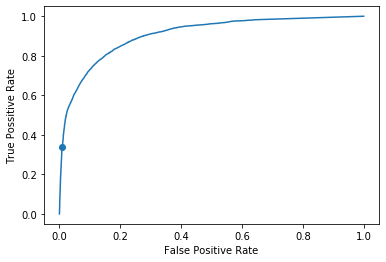

In [9]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

probs = pd.DataFrame(rf.predict_proba(x))[0]
results = roc_curve(y, probs, pos_label = 'College')
plt.plot(results[0], results[1])
plt.show

plt.scatter(results[0][287], results[1][287])
plt.xlabel('False Positive Rate') # how many of the pred college were uni
plt.ylabel('True Possitive Rate') # how many college were actually college

y_new = [1 * (element == 'College') for element in y]

print('Area under the ROC curve: ' + str(roc_auc_score(y_new, probs)))

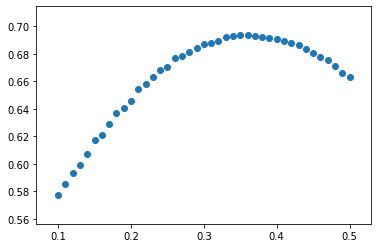

In [10]:
import numpy as np
f1s = []
ts = np.linspace(0.1, 0.5, 41, endpoint=True)
for t in ts:
    y_pred_new = (probs >= t)
    f1s.append(f1_score(y_new, y_pred_new, average = None)[1])
plt.scatter(ts, f1s)

In [11]:
new_threshold = ts[f1s.index(max(f1s))]
new_threshold

0.36

In [12]:
# Predict School Type for testing data
y_pred_new = (probs >= new_threshold)

# --- Confusion Matrix ---
test_CM = pd.DataFrame(confusion_matrix(y_new, y_pred_new))
test_CM.rename(columns = {1: 'Pred_Col', 0: 'Pred_Uni'}, index = {1: 'Obs_Col', 0: 'Obs_Uni'}, inplace = True)
test_CM

,Pred_Uni,Pred_Col
Obs_Uni,11841,1207
Obs_Col,986,2482


In [13]:
f1_score(y_new, y_pred_new, average = None)[1]

0.6935866983372921

In [14]:
probs_df = pd.DataFrame(rf.predict_proba(x), columns=['Prob.Col', 'Prob.Uni'])
probs_df['Pred'] = probs_df['Prob.Col'].apply(lambda x: 'Col' if x >= new_threshold else 'Uni')

In [15]:
probs_df.to_csv('RF_Predictions.csv')